In [1]:
# import the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load the Data:

In [3]:
df_train = pd.read_table('/content/crime-train.txt')
df_test = pd.read_table('/content/crime-test.txt')

In [4]:
# take a peek at the data
df_train.head()

,ViolentCrimesPerPop,population,householdsize,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,FemalePctDiv,TotalPctDiv,PersPerFam,PctFam2Par,...,PctSpeakEnglOnly,PctNotSpeakEnglWell,PctLargHouseFam,PctLargHouseOccup,PersPerOccupHous,PersPerOwnOccHous,PersPerRentOccHous,PctPersOwnOccup,PctPersDenseHous,PctHousLess3BR,MedNumBR,HousVacant,PctHousOccup,PctHousOwnOcc,PctVacantBoarded,PctVacMore6Mos,MedYrHousBuilt,PctHousNoPhone,PctWOFullPlumb,OwnOccLowQuart,OwnOccMedVal,OwnOccHiQuart,RentLowQ,RentMedian,RentHighQ,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn
0,0.67,-0.45,-1.85,-1.06,0.67,0.08,-0.85,-0.34,0.68,-0.24,0.88,-0.89,-0.26,-1.27,-0.13,-0.53,-0.43,0.10,0.06,0.23,-0.26,-0.11,-0.20,-0.36,-0.28,-0.82,-0.71,-0.29,-0.46,1.32,0.86,-1.66,0.14,-0.44,2.95,1.11,2.41,2.75,-1.28,-0.90,...,0.24,-0.23,-0.55,-0.80,-1.72,-1.29,-1.24,-1.54,0.07,1.88,-1.23,-0.38,0.36,-1.67,-0.85,-0.97,0.67,-0.43,-1.18,-0.24,-0.27,-0.25,0.34,0.04,-0.09,-0.07,-1.18,-0.69,-1.16,-0.29,-0.23,-0.02,-0.53,-1.08,-0.13,-0.66,-0.41,-0.56,1.26,-0.39
1,0.43,-0.45,-0.27,-0.22,-0.17,-0.34,-0.58,-0.50,-1.57,-0.29,0.12,-0.50,-0.59,-0.52,0.37,2.15,-0.48,-0.42,-0.42,-0.12,-0.81,-0.17,0.02,-0.36,-0.14,-0.21,0.23,-0.82,-0.02,0.45,-0.38,-0.86,0.50,-0.65,0.92,-0.14,1.27,1.12,-0.24,-0.95,...,0.41,-0.50,-0.34,-0.27,-0.01,0.16,0.14,-0.72,-0.17,0.09,0.73,-0.44,0.72,-0.75,0.39,-0.71,0.11,0.85,1.00,-0.38,-0.40,-0.46,-0.35,-0.39,-0.62,-0.35,-0.06,-0.32,-0.64,-0.29,-0.23,-0.33,-0.58,0.03,0.22,-0.46,-0.50,-0.11,-0.62,-0.39
2,0.12,-0.14,1.87,0.55,0.04,0.02,-1.19,-0.03,0.68,1.05,1.81,-0.40,-0.37,-0.64,-0.53,2.03,0.68,0.05,0.17,0.58,-0.26,-0.37,0.29,-0.36,-0.89,-1.06,-0.66,-0.25,-0.17,1.20,-0.18,0.05,-0.11,-0.28,-0.66,0.09,0.01,-0.30,1.70,0.19,...,0.11,-0.32,1.49,1.93,2.29,1.74,3.15,1.91,-0.32,-2.81,0.73,-0.44,1.29,2.22,1.82,0.19,0.11,-0.64,-0.64,-0.11,-0.23,-0.34,1.84,1.57,1.40,2.37,0.83,0.32,0.34,-0.29,-0.23,-0.11,-1.51,1.07,0.07,-0.01,-0.41,0.77,0.52,-0.39
3,0.03,-0.38,0.53,-0.28,-0.79,-0.64,-0.35,-0.34,0.46,0.66,0.88,-0.64,1.04,-0.18,-0.94,1.38,0.43,0.42,0.22,-0.06,-1.24,2.14,0.51,-0.43,-1.06,-0.31,-0.41,-0.15,-1.20,0.86,1.35,-0.35,0.14,0.10,-1.32,-0.94,-1.64,-1.55,0.14,1.48,...,0.41,-0.46,-0.55,-0.32,0.75,0.67,-0.18,1.66,-0.79,-1.77,0.73,-0.44,0.88,1.73,-0.76,0.62,1.01,-0.88,-0.50,0.20,0.20,0.13,0.24,-0.06,-0.17,-0.02,-1.59,0.32,-1.01,-0.29,-0.23,-0.46,0.54,0.58,-0.08,-0.61,-0.23,-0.70,-0.62,-0.39
4,0.14,-0.30,-1.12,-0.74,-0.10,-0.40,-0.30,-0.19,0.68,0.76,0.67,-0.45,0.64,-1.10,-0.76,-1.37,1.23,1.93,2.10,2.79,0.46,1.01,1.17,-0.36,-0.80,-0.87,-1.30,2.10,-1.30,0.86,-1.02,1.88,-1.67,2.52,0.16,0.77,0.70,0.47,-0.31,0.04,...,-1.48,0.59,-0.09,-0.32,-1.02,0.23,-1.18,-0.88,0.35,1.36,-1.23,-0.38,0.62,-1.34,-0.20,-0.81,-1.05,-1.01,-0.94,3.01,3.18,3.11,1.48,1.23,1.04,1.11,-0.12,0.75,-1.53,-0.29,-0.23,2.10,-0.92,-0.25,0.52,-0.06,-0.50,1.71,-0.27,-0.39


In [5]:
print("No. of training samples: ", len(df_train))
print("No. of test samples: ", len(df_test))

No. of training samples:  1595
No. of test samples:  399


In [40]:
# Create the inputs and the output labels
X_train = df_train.drop('ViolentCrimesPerPop', axis=1)
y_train = df_train['ViolentCrimesPerPop']

X_test = df_test.drop('ViolentCrimesPerPop', axis=1)
y_test = df_test['ViolentCrimesPerPop']

# Build the Lasso Model

In [41]:
class Lasso_Regression:
    def __init__(self, lambd=1e-8):
        self.lambd = lambd
        self.w = None
        self.b = None

    '''
    the cost function is given by the equation:
    arg min Sum(xT.w + b - y)^2 + lambda*L1Norm
    '''
    def cost(self, X, y):
        return (np.linalg.norm(X.dot(self.w) + self.b - y))**2 + self.lambd*np.linalg.norm(self.w, ord = 1)

    def grad_desc(self, X, y, tolerance=1e-4):
        iteration = 0
        n, d = X.shape
        
        w_init = np.zeros(d)
        w_prev = w_init + np.inf 
        self.w = w_init
        loss_hist = []
        a = 2*np.sum(X**2, axis = 0) 

        while np.linalg.norm(self.w-w_prev, ord = np.inf) >= tolerance:
            iteration += 1
            w_prev = np.copy(self.w)
            self.b = np.mean(y - X.dot(self.w))

            for k in range(d):
                x = np.arange(d) != k
                ak = a[k]
                ck = 2*np.sum(X[:,k]*(y - (self.b + X[:, x].dot(self.w[x]))), axis = 0)
                self.w[k] = np.float(np.piecewise(ck, 
                    [ck < -self.lambd, ck > self.lambd, ], 
                    [(ck+self.lambd)/ak, (ck-self.lambd)/ak, 0]))
            if iteration % 10 == 0:
                print('Iteration: ', iteration, ' Loss:', self.cost(X,y))
            loss_hist.append(self.cost(X,y))
        return loss_hist
    
    def predict(self, X):
        return np.dot(X, self.w) + self.b

In [42]:
def mse(x, y):
    return np.mean((x-y)**2)

In [43]:
nonzeros = []
w_regularization_path = []
train_mse = []
test_mse = []
lambda_max = np.max(np.sum(2*X_train.values*(y_train.values - 
    np.mean(y_train.values))[:, None], axis = 0))
lambdas = [lambda_max/(2**i) for i in range(10)]

w_init = None
for lambd in lambdas:
    model = Lasso_Regression(lambd = lambd)
    model.grad_desc(X_train.values,y_train.values,tolerance = 1e-4)
    w_init = np.copy(model.w)
    w_regularization_path.append(np.copy(model.w))
    total_num_of_nonzeros = np.sum(abs(model.w) > 1e-14)
    nonzeros.append(total_num_of_nonzeros)
    train_mse.append(mse(model.predict(X_train), y_train))
    test_mse.append(mse(model.predict(X_test), y_test))

Iteration:  10  Loss: 72.63497866933531
Iteration:  10  Loss: 57.141981860293086
Iteration:  10  Loss: 45.72015313298177
Iteration:  20  Loss: 45.40643693311549
Iteration:  10  Loss: 38.73250758225795
Iteration:  20  Loss: 38.19134044922642
Iteration:  10  Loss: 35.295409330718755
Iteration:  20  Loss: 34.01728714888665
Iteration:  30  Loss: 33.83184656368384
Iteration:  40  Loss: 33.83100134286467
Iteration:  10  Loss: 33.7651254394018
Iteration:  20  Loss: 31.77848398625377
Iteration:  30  Loss: 31.376986384208312
Iteration:  40  Loss: 31.265982445843626
Iteration:  10  Loss: 32.28343748007829
Iteration:  20  Loss: 30.692085183964608
Iteration:  30  Loss: 30.063236214101003
Iteration:  40  Loss: 29.807673834683733
Iteration:  50  Loss: 29.715110408169252
Iteration:  60  Loss: 29.694997910780064
Iteration:  70  Loss: 29.69233939225812
Iteration:  10  Loss: 30.971600614019234
Iteration:  20  Loss: 29.734769006691113
Iteration:  30  Loss: 29.219394528697126
Iteration:  40  Loss: 28.9204

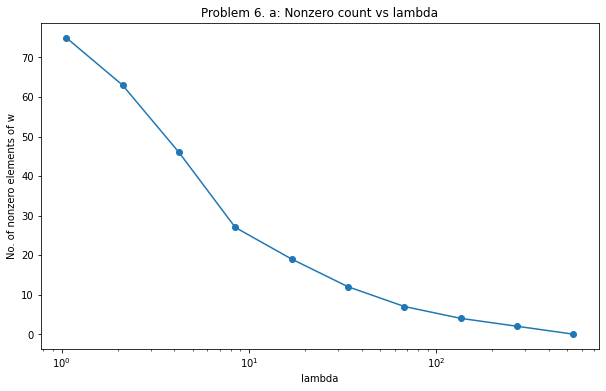

In [51]:
#Part a
plt.figure(figsize = (10,6))
plt.plot(lambdas, nonzeros, '-o')
plt.xscale('log')
plt.title('Problem 6. a: Nonzero count vs lambda')
plt.xlabel('lambda')
plt.ylabel('No. of nonzero elements of w')
plt.show()

Text(0, 0.5, 'Coefficient')

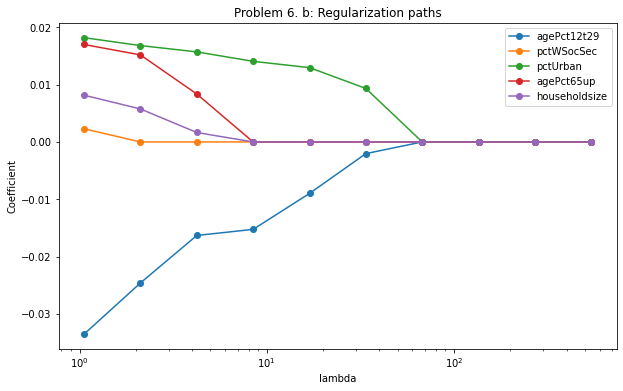

In [55]:
#Part b
plt.figure(figsize = (10,6))
w_regularization_path = np.array(w_regularization_path)
coeffs_names = ['agePct12t29', 'pctWSocSec', 'pctUrban', 'agePct65up', 'householdsize']
coeffs_indices = [X_train.columns.get_loc(i) for i in coeffs_names]
for coeff_path, label in zip(w_regularization_path[:, coeffs_indices].T, coeffs_names):
    plt.plot(lambdas, coeff_path, '-o', label=label,)
plt.legend()
plt.xscale('log')
plt.title('Problem 6. b: Regularization paths')
plt.xlabel('lambda')
plt.ylabel('Coefficient')

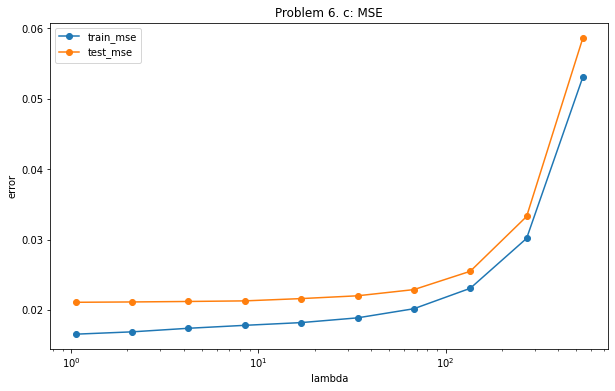

In [58]:
#Part c
plt.figure(figsize = (10,6))
plt.plot(lambdas, train_mse, '-o', label = 'train_mse')
plt.plot(lambdas, test_mse, '-o', label = 'test_mse')
plt.xscale('log')
plt.title('Problem 6. c: MSE')
plt.legend()
plt.xlabel('lambda')
plt.ylabel('error')
plt.show()

Iteration:  10  Loss: 37.973951124849314
Iteration:  20  Loss: 37.2883102459297
Iteration:  30  Loss: 37.24666787455096


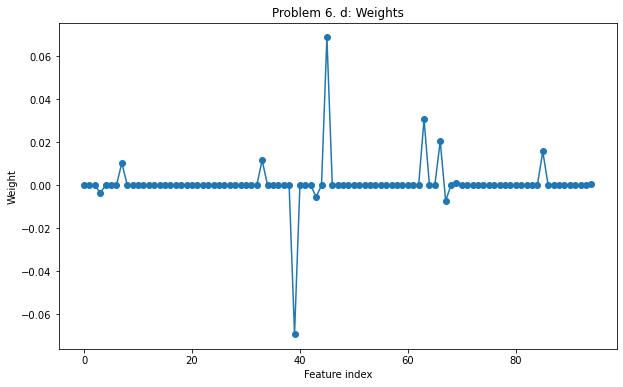

Largest positive weight: PctIlleg
Largest negative weight: PctKids2Par


In [59]:
#Part d
model = Lasso_Regression(lambd = 30)
model.grad_desc(X_train.values,y_train.values, tolerance = 1e-4)
plt.figure(figsize = (10,6))
plt.plot(model.w, '-o')
plt.title('Problem 6. d: Weights')
plt.xlabel('Feature index')
plt.ylabel('Weight')
plt.show()

print('Largest positive weight:', X_train.columns[np.argmax(model.w)])
print('Largest negative weight:', X_train.columns[np.argmin(model.w)])